In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import math
import os
import gpxpy
import pyproj
import scipy
from tabulate import tabulate
from IPython.display import HTML, display
from datetime import timedelta
from copy import deepcopy
import matplotlib.colors as mcolors

# Established Methods

## Munter method

TIME = (DISTANCE + ELEVATION CHANGE / 100)/ RATE
Peicewise for uphill, downhill, and flat. You use a different rate parameter for each. What's the cutoff for uphill, downhill, and flat? Unclear: caltopo doesn't say https://training.caltopo.com/all_users/objects/existing-lines#travel

The first thing we want to look at is what this in practice means for our pace. The basic assumption that all these methods state is that there is some cost function relating pace to grade. What does this look like for the munter method? 



In [3]:
lower_grade_cutoff = -0.5
upper_grade_cutoff = 0.5 

In [4]:
# Pace in m/s according to the munter method
def munter_pace(grade, rate):
    return (5 * rate) / (180 * abs(grade) + 18) # By manipulation of the munter formula

In [5]:
def plot_pace_vs_grade_function(pacefunc, lower_cutoff, upper_cutoff, label=None, linestyle=None):
    
    if(linestyle==None):
        linestyle = '-'

    # Data generation
    grades = np.linspace(lower_cutoff, upper_cutoff, 1000)
    vfunc = np.vectorize(pacefunc)
    paces = vfunc(grades)

    # Plotting
    plt.plot(grades * 100, paces, label=label, linestyle=linestyle)
    
def plot_pace_vs_grade(pacefunc, title="Pace vs Grade", lower_cutoff=lower_grade_cutoff, upper_cutoff=upper_grade_cutoff):
    plot_pace_vs_grade_function(pacefunc, lower_cutoff, upper_cutoff)
    plt.xlabel("Grade (%)")
    plt.ylabel("Pace (m/s)")
    plt.title(title)
    plt.grid()
    plt.show()

Here's the munter plot for pace with a rate of 4, which is a pretty standard assumption. 

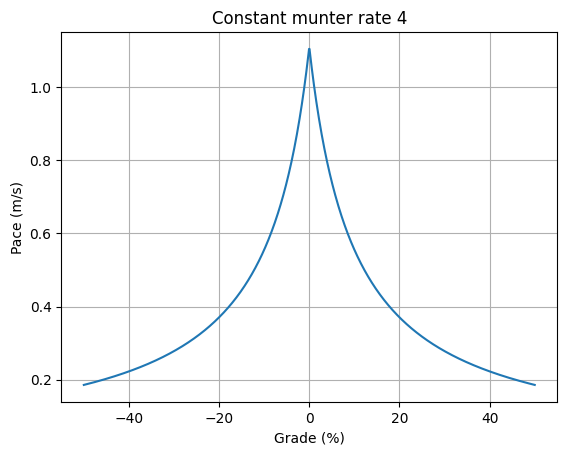

In [6]:
plot_pace_vs_grade(partial(munter_pace, rate=4), title="Constant munter rate 4")

Already, we see one problem with this method. Which is that it's symetrical around the 0 grade, which doesn't really track with what we intuitively expect, going downhill is a little faster than going uphill (up to some limit, extremely steep downhill is dangerous so we move more slowly and carefully!). The overall shape is roughly what we might expect though, fast near flat, and a little slower in both directions. 

The munter method corrects for this shortcoming by telling us to break our trip into uphill, downhill, and flat segments, then apply a different rate to those. This gives the following function:

In [7]:
def munter_pace_peicewise_private(grade, downhill_rate, flat_rate, uphill_rate):
    if(grade > .05):
        return munter_pace(grade, uphill_rate)
    elif(grade < -0.05):
        return munter_pace(grade, downhill_rate)
    else:
        return munter_pace(0, flat_rate) # Matter of contention, should we actually put in the grade?
    
munter_pace_peicewise = np.vectorize(munter_pace_peicewise_private, excluded=['downhill_rate', 'flat_rate', 'uphill_rate'])

Caltopo uses the following rate schedule as a suggestion: 
Hike: Down=6, Flat=6, Up=4
Ski: Down=10, Flat=6, Up=4
Bushwack: Down=2, Flat=2, Up=2 

Let's look at the hike pace function first:

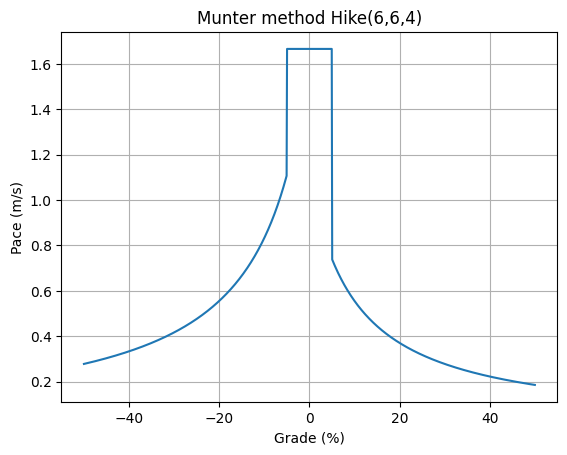

In [8]:
plot_pace_vs_grade(partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=6), title="Munter method Hike(6,6,4)")

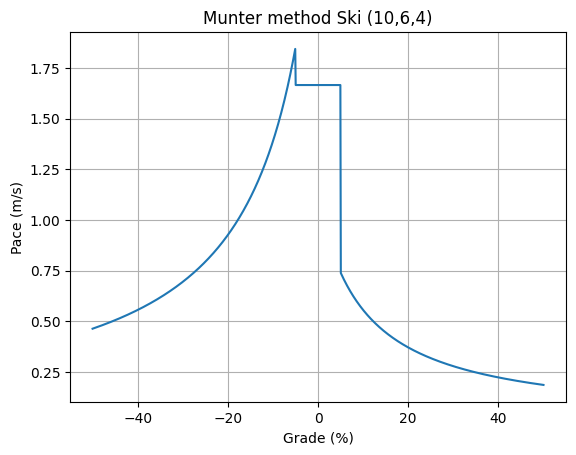

In [9]:
plot_pace_vs_grade(partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), title="Munter method Ski (10,6,4)")

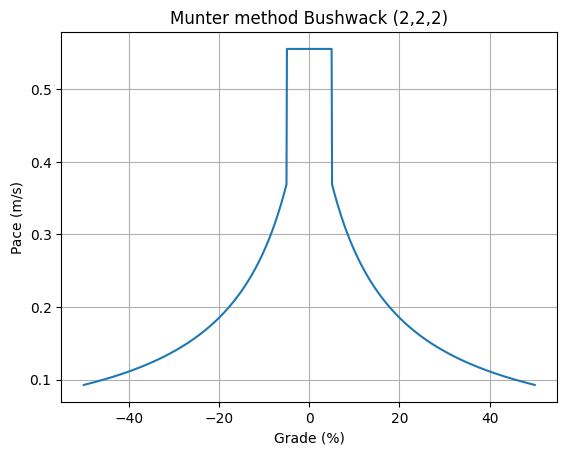

In [10]:
plot_pace_vs_grade(partial(munter_pace_peicewise, uphill_rate=2, flat_rate=2, downhill_rate=2), title="Munter method Bushwack (2,2,2)")

Here's all three together on one graph for comparison: 

In [11]:
def plot_pace_vs_grade_multi(pacefuncs, titles, colors, bounds, legend_title="", chart_title="", line_styles=None, line_widths=None, alphas=None):
    if line_styles is None:
        line_styles = ['-'] * len(pacefuncs)
    if line_widths is None:
        line_widths = [1] * len(pacefuncs)
    if alphas is None:
        alphas = [1] * len(pacefuncs)

    # Plotting
    for pacefunc, title, color, (lower_cutoff, upper_cutoff), line_style, line_width, alpha in zip(pacefuncs, titles, colors, bounds, line_styles, line_widths, alphas):
        # Data generation
        grades = np.linspace(lower_cutoff, upper_cutoff, 1000)
        vfunc = np.vectorize(pacefunc)
        paces = vfunc(grades)
        plt.plot(grades * 100, paces, label=title, color=color, linestyle=line_style, linewidth=line_width, alpha=alpha)

    plt.xlabel("Grade (%)")
    plt.ylabel("Pace (m/s)")
    plt.title(chart_title)
    plt.legend(title=legend_title)
    plt.grid()
    plt.show()

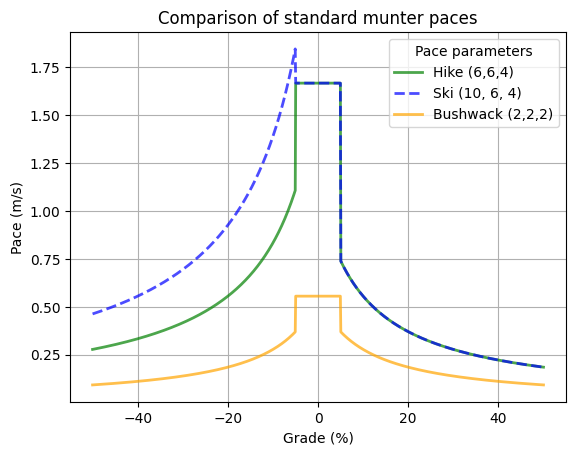

In [12]:
plot_pace_vs_grade_multi(
    pacefuncs=[partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=6), 
               partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
               partial(munter_pace_peicewise, uphill_rate=2, flat_rate=2, downhill_rate=2)],
    titles=["Hike (6,6,4)", "Ski (10, 6, 4)", "Bushwack (2,2,2)"],
    colors=["green", "blue", "orange"],
    bounds=[(-0.5, 0.5), (-0.5, 0.5), (-0.5, 0.5)],
    legend_title="Pace parameters",
    chart_title="Comparison of standard munter paces",
    line_styles=['-', '--', '-'],
    line_widths=[2, 2,2],
    alphas=[0.7, 0.7, 0.7]
)

Observe: Things look super weird for ski! Why is that? One good argument is that when backcountry skiing, we really need two functions, one for when your skins are off and one for when your skins are on. The discontinuity in the downhill to flat section is actually sensible because you would normally be expected to count even moderately downhill sections as downhill for the purposes of skiing, and that is indeed much faster than skinning up that section in the other direction.

To illustrate my point, here is chart of what this dual-regime type of pacing would look like: 

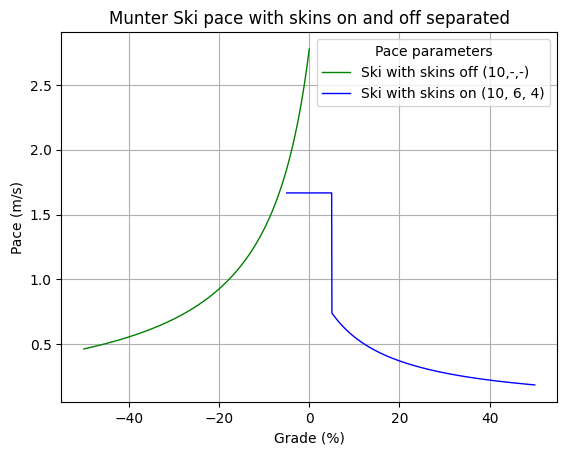

In [13]:
plot_pace_vs_grade_multi(
    pacefuncs=[partial(munter_pace, rate=10), 
               partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)],
    titles=["Ski with skins off (10,-,-)", "Ski with skins on (10, 6, 4)"],
    colors=["green", "blue"],
    bounds=[(-0.5, 0), (-0.05, 0.5)],
    legend_title="Pace parameters",
    chart_title="Munter Ski pace with skins on and off separated",
)

Pulling apart this function like this can show us a big problem though (and the reason caltopo doesn't do munter calculations like this!). Skiing without skins on a slightly negative grade is not faster than skiing without skins on a moderately steep grade! That green line should max out somewhere over in the -20% range, depending on ski ability, not at 0!

Instead, caltopo and presumably people doing math by hand, ought to be using the piecewise weird function from before. That avoids the problem of runaway downhill speeds near zero grade, but we still end up with our downhill speed maxing out at a measly -5% grade, which is probably only true for people that are still learning on the bunny hill. 

## Tobler's Method

In [14]:
# Pace in m/s for toblers hiking function
def toblers_hiking_pace(grade, basepace, decayrate, bias):
    km_per_hr_pace = basepace * math.e ** (decayrate * abs(grade + bias))
    
    return (km_per_hr_pace * 1000) / (60*60)

# Pace in m/s for toblers hiking function
def toblers_hiking_pace_standard(grade):    
    return toblers_hiking_pace(grade, 6, -3.4, 0.05)

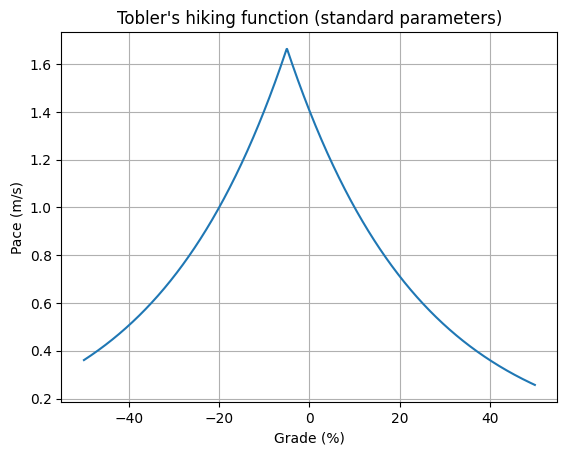

In [15]:
plot_pace_vs_grade(toblers_hiking_pace_standard, title="Tobler's hiking function (standard parameters)")

Observe: Tobler's hiking function has a characteristic that we should really like, which is that the maximum pace is on a slight downhill. This is what we actually expect in practice. Otherwise, the shape of the function is similar to the munter method, though it has slightly less steep drop off. 

Let's look at Tobler's hiking function alongside the munter method hike function

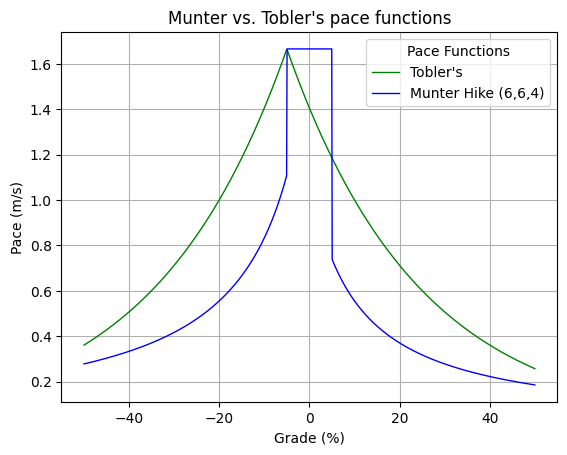

In [16]:
plot_pace_vs_grade_multi(
    pacefuncs=[toblers_hiking_pace_standard, 
               partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=6)],
    titles=["Tobler's", "Munter Hike (6,6,4)"],
    colors=["green", "blue"],
    bounds=[(-0.5, 0.5), (-0.5, 0.5)],
    legend_title="Pace Functions",
    chart_title="Munter vs. Tobler's pace functions",
)

# Example Mt. Si. 

In [40]:
mt_si_dx = 5279 # meters
mt_si_dy = 1012 # meters

mt_si_uphill_speed = toblers_hiking_pace_standard(-mt_si_dy/mt_si_dx)

print(mt_si_uphill_speed) # m/s 

print(((1/mt_si_uphill_speed) * mt_si_dx)/(60 * 60))

1.029461152052912
1.4244237249406375


# Emperical Data

## Getting Real data from my GPX files

In [213]:
# Reading all GPX tracks from our dataset and parsing them
gpx_files = []
dir_path = os.path.join(os.path.abspath('.'), 'tracks')
for file in os.listdir(dir_path):
    file_path = os.path.join(dir_path, file)
    if os.path.isfile(file_path) and file_path.endswith(".gpx"):
        with open(file_path, 'r') as f:
            gpx = gpxpy.parse(f)
            assert len(gpx.tracks) == 1 # All my data has only one track and segment per file
            assert len(gpx.tracks[0].segments) == 1
            gpx_files.append(gpx)

In [214]:
tracks = [gpx.tracks[0] for gpx in gpx_files]

In [215]:
print([(idx, t.name) for (idx, t) in enumerate(tracks)])

[(0, 'Morning Backcountry Ski'), (1, 'Plan 🅱️'), (2, 'September turns '), (3, 'Morning Backcountry Ski'), (4, 'Evening Run'), (5, 'Evening Run'), (6, 'Evening Run'), (7, 'Morning Run'), (8, 'Morning Trail Run'), (9, 'Morning Run'), (10, 'Evening Run'), (11, 'Morning Alpine Ski'), (12, 'Lunch Hike'), (13, 'Evening Run'), (14, 'Morning Run'), (15, 'Lunch Run'), (16, 'Afternoon Ride'), (17, 'Evening Run'), (18, 'Evening Run'), (19, 'Morning Backcountry Ski'), (20, 'Afternoon Run + a couple of hill sprints '), (21, 'Charlottesville'), (22, 'Tatie Peak Trail Run'), (23, 'Evening Run'), (24, 'Morning Backcountry Ski'), (25, 'Evening Run'), (26, 'Evening Backcountry Ski'), (27, 'Evening Hike'), (28, 'Morning Run'), (29, 'Morning Run'), (30, 'Evening Trail Run'), (31, 'Morning Backcountry Ski'), (32, 'Afternoon Run'), (33, 'Slopes - An evening skiing at Summit at Snoqualmie-West'), (34, 'Afternoon Hike'), (35, 'Morning Ride'), (36, 'Star + Courtney + Oval'), (37, 'Hogsback Excursion '), (38, '

In [216]:
tracks_by_type = {}
for track in tracks:
    if(track.type in tracks_by_type):
        tracks_by_type[track.type].append(track)
    else:
        tracks_by_type[track.type] = [track]

In [217]:
print(tracks_by_type.keys())

dict_keys(['Backcountry Ski', 'Run', 'Hike', 'Alpine Ski', 'Ride', 'Snowshoe', 'Walk'])


In [218]:
# We only care about some track types
# Others, like running, are interesting but should be addressed separately
# Some, like resort skiing, are just not relavent
ACTIVITY_SKI = "Backcountry Ski"
ACTIVITY_HIKE = "Hike"
analyzed_types = {ACTIVITY_SKI, ACTIVITY_HIKE}
tracks_by_type = {k: v for k, v in tracks_by_type.items() if k in analyzed_types}

In [219]:
print(tracks_by_type.keys())

dict_keys(['Backcountry Ski', 'Hike'])


In [220]:
for tracktype, tracks in tracks_by_type.items():
    print(f"Collected {len(tracks)} tracks of type {tracktype}")

Collected 38 tracks of type Backcountry Ski
Collected 33 tracks of type Hike


In [221]:
# Calculates the distance in meters between two geographical points using their longitude and latitude values.
def distance(long1, lat1, long2, lat2):
    geodesic = pyproj.Geod(ellps='WGS84')
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return distance

# Takes a segment and divides it into chunks of a specified length
# Returns a list of tuples, each containing the starting point, ending point, and distance of a chunk.
def chunkify_segment(segment, chunklength):
    chunks = []

    current_chunk_distance = 0
    current_chunk_beginning_point = None 
    current_chunk_last_point = None

    for point in segment.points:
        if(current_chunk_beginning_point == None):
            current_chunk_beginning_point = point 
            current_chunk_last_point = point 
            continue 

        current_chunk_distance += distance(current_chunk_last_point.longitude, current_chunk_last_point.latitude, point.longitude, point.latitude)
        current_chunk_last_point = point

        if(current_chunk_distance >= chunklength):
            chunks.append((current_chunk_beginning_point, current_chunk_last_point, current_chunk_distance))
            current_chunk_distance = 0
            current_chunk_beginning_point = current_chunk_last_point

    if(current_chunk_distance > 0):
        chunks.append((current_chunk_beginning_point, current_chunk_last_point, current_chunk_distance))

    return chunks

# Get chunks from a gpx track
def chunkify_track(track, chunklength=50):
    assert len(track.segments) == 1
    return chunkify_segment(track.segments[0], chunklength)

# Get chunks from a set of tracks separated by type
def get_chunks_for_trackset(track_set):
    chunks_by_activity_type = {}

    for activity_type, tracks in track_set.items():
        chunks = []
        for track in tracks: 
            new_chunks = chunkify_track(track)
            assert new_chunks != None
            assert len(new_chunks) > 0
            chunks.extend(new_chunks)
        chunks_by_activity_type[activity_type] = chunks
        
    return chunks_by_activity_type

In [222]:
# Extracting a grade and a pace from a chunk
def grade_pace_time_for_chunk(chunk):
    (beginning, end, distance) = chunk
    elevation_change = end.elevation - beginning.elevation
    grade = elevation_change/distance

    time = end.time - beginning.time
    time_secs = time.total_seconds()
    
    if(time_secs == 0):
        return None # Edge case, a chunk could have no elapsed time. Should be very uncommon.
        
    pace = distance/time_secs

    return(grade, pace, time.total_seconds(), distance)

def get_grade_pace_data_for_chunks(chunks):
    per_chunk_data = [grade_pace_time_for_chunk(chunk) for chunk in chunks]
    return np.array([x for x in per_chunk_data if x != None])

# Get consolidated grade pace data for a set of tracks separated by type
def get_grade_pace_data_for_trackset(trackset):
    chunks_by_type = get_chunks_for_trackset(trackset)
    
    pace_data_by_activity_type = {}
    for activity_type, chunks in chunks_by_type.items():
        pace_data = get_grade_pace_data_for_chunks(chunks)
        pace_data_by_activity_type[activity_type] = pace_data
    return pace_data_by_activity_type

In [223]:
pace_data = get_grade_pace_data_for_trackset(tracks_by_type)

In [224]:
print(pace_data)

{'Backcountry Ski': array([[-1.96975395e-02,  9.76303119e-01,  5.20000000e+01,
         5.07677622e+01],
       [ 0.00000000e+00,  6.87175484e-01,  7.30000000e+01,
         5.01638103e+01],
       [ 5.87124461e-02,  3.49975969e-01,  1.46000000e+02,
         5.10964914e+01],
       ...,
       [-7.81609178e-02,  1.31221722e+00,  3.90000000e+01,
         5.11764717e+01],
       [-7.84545165e-02,  1.30730654e+00,  3.90000000e+01,
         5.09849551e+01],
       [-5.70023840e-02,  1.16954173e+00,  4.50000000e+01,
         5.26293777e+01]]), 'Hike': array([[ 7.90359372e-02,  1.26524722e+00,  4.00000000e+01,
         5.06098889e+01],
       [-3.91893380e-02,  1.37930511e+00,  3.70000000e+01,
         5.10342890e+01],
       [-1.99570338e-02,  1.51841354e+00,  3.30000000e+01,
         5.01076467e+01],
       ...,
       [ 0.00000000e+00,  1.13960618e+00,  4.40000000e+01,
         5.01426717e+01],
       [-5.85822660e-02,  8.82931670e-01,  5.80000000e+01,
         5.12100369e+01],
       [ 2.

## A Quick Visualization

In [225]:
def scatter_plot_grade_and_pace_data(data, title="Grade vs Pace", xlimits=None):
    grades = data[:, 0] * 100
    paces = data[:, 1]

    # Plot the data
    if(xlimits != None):
        plt.xlim(xlimits)
    plt.scatter(grades, paces, s=5)  # s=10 sets the size of the dots
    plt.xlabel("Grade (%)")
    plt.ylabel("Pace (m/s)")
    plt.title(title)
    plt.show()

In [226]:
def scatter_grade_and_pace_for_all_types(pace_data_set):
    for activity_type, data in pace_data_set.items():
        scatter_plot_grade_and_pace_data(pace_data[activity_type], title=f"Grade vs Pace ({activity_type})")

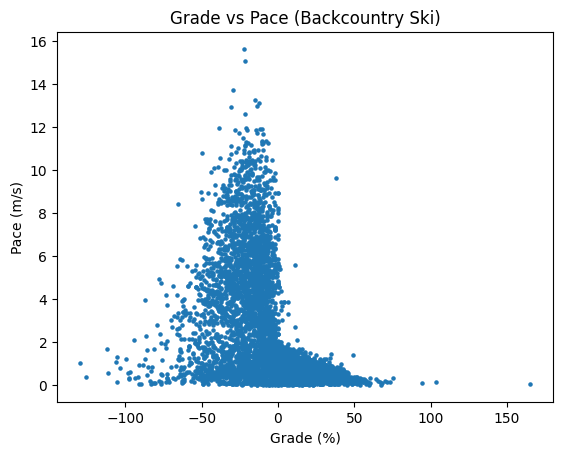

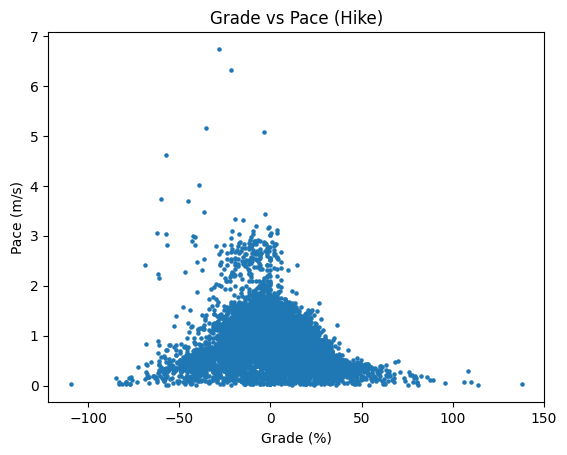

In [227]:
scatter_grade_and_pace_for_all_types(pace_data)

In [228]:
def percentile_lines_plot(grades, paces, binning=10, percentiles=[25, 50, 75], colors=None, linestyles=None, threshold=0):
    bins = np.linspace(grades.min(), grades.max(), binning+1)
    bin_indices = np.digitize(grades, bins)
    
    if(linestyles == None):
        linestyles = ['-'] * len(percentiles)

    for idx, percentile in enumerate(percentiles):
        percentile_values = []
        for b in range(1, len(bins)):
            values_in_bin = paces[bin_indices == b]
            if values_in_bin.size >= threshold:
                percentile_value = np.percentile(values_in_bin, percentile)
                percentile_values.append(percentile_value)
            else:
                percentile_values.append(np.nan)
                
        color = None
        if(colors != None):
            color = colors[idx]
            
        plt.plot(bins[:-1], percentile_values, label=f'{percentile}th Percentile', color=color, linestyle=linestyles[idx])

def plot_grade_and_pace_percentiles(data, title="Grade vs Pace", xlimits=None, binning=10, percentiles=[25, 50, 75], threshold=5):
    grades = data[:, 0] * 100
    paces = data[:, 1]

    if xlimits is not None:
        plt.xlim(xlimits)

    percentile_lines_plot(grades, paces, binning, percentiles, threshold=threshold)

    plt.xlabel("Grade (%)")
    plt.ylabel("Pace (m/s)")
    plt.title(title)
    plt.legend()
    plt.show()
    
    
# Threshold is there because my ski data has one point with high grade which looks ugly on the plot

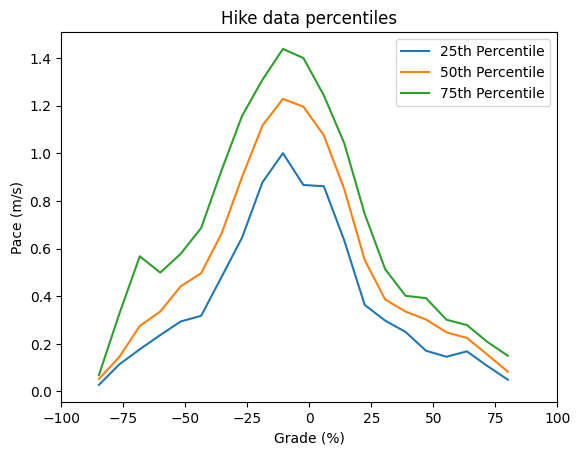

In [229]:
plot_grade_and_pace_percentiles(pace_data[ACTIVITY_HIKE], title="Hike data percentiles", binning=30, xlimits=[-100,100])

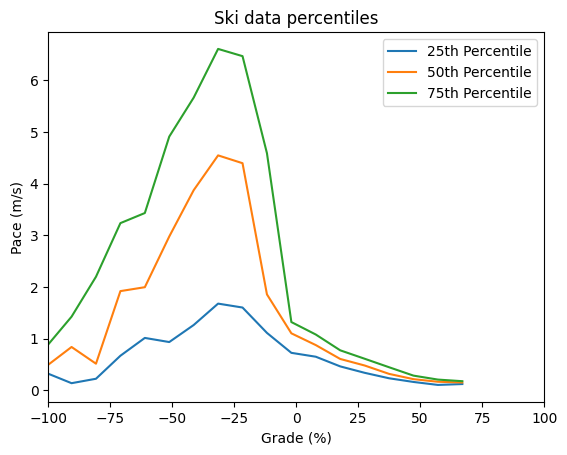

In [230]:
plot_grade_and_pace_percentiles(pace_data[ACTIVITY_SKI], title="Ski data percentiles", binning=30, xlimits=[-100,100])

## Visualizing Pace Functions vs. Real Data

In [231]:
def plot_data_percentiles_and_pacefuncs(data, pacefuncs, pacefunc_labels, title=""):
    grades = data[:, 0] * 100
    paces = data[:, 1]

    plt.xlim([-100, 100])

    percentile_lines_plot(grades, paces, binning=30, percentiles=[25, 55, 75], colors=["green", "green", "green"], linestyles=["--"]*3, threshold=5)
    
    for pacefunc, label in zip(pacefuncs, pacefunc_labels):
        plot_pace_vs_grade_function(pacefunc, -1, 1, label=label)

    plt.xlabel("Grade (%)")
    plt.ylabel("Pace (m/s)")
    plt.title(title)
    plt.legend()
    plt.show()

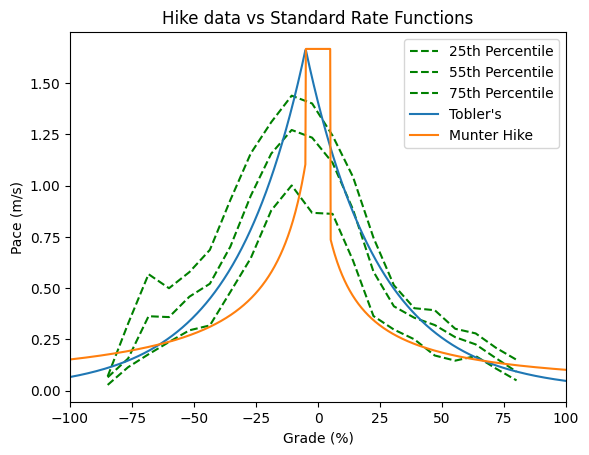

In [232]:
plot_data_percentiles_and_pacefuncs(pace_data[ACTIVITY_HIKE], 
                                   [toblers_hiking_pace_standard, 
               partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=6)], 
                                    ["Tobler's", "Munter Hike"],
                                   title="Hike data vs Standard Rate Functions")

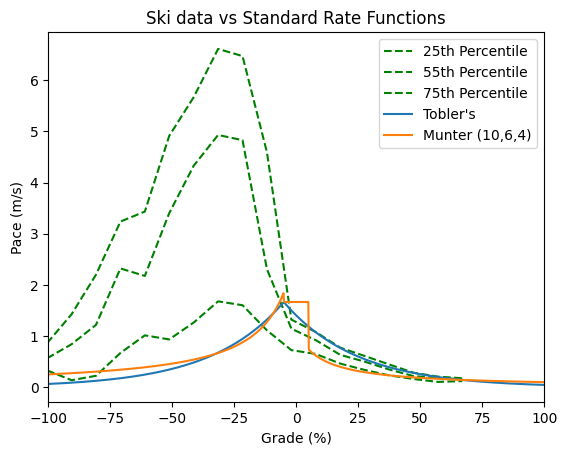

In [233]:
plot_data_percentiles_and_pacefuncs(pace_data[ACTIVITY_SKI], 
                                   [toblers_hiking_pace_standard, 
               partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)], 
                                    ["Tobler's", "Munter (10,6,4)"],
                                   title="Ski data vs Standard Rate Functions")

## Quantitative Comparison of Pace Functions vs. Real Data

In [234]:
# Utility for printing a nicely formatted table of metrics for pacefunctions x datasets
def check_metric(metric, datasets, dataset_names, pacefuncs, pacefunc_names):
    table = [["Dataset"] + pacefunc_names] # Firstrow headers
    
    for dataset, ds_name in zip(datasets, dataset_names):
        row = [ds_name]
        for pacefunc in pacefuncs:
            result = metric(dataset, pacefunc)
            row.append(result)
        table.append(row)
        
    return tabulate(table, headers="firstrow", tablefmt='html')

In [235]:
# Code for checking r^2 fits for data and pace functions
def check_r2_fit(data, pacefunc):
    grades = data[:, 0]
    actual_rates = data[:, 1]
    
    vfunc = np.vectorize(pacefunc)
    predicted_rates = vfunc(grades)

    corr_matrix = np.corrcoef(actual_rates, predicted_rates)
    corr = corr_matrix[0,1]
    R_sq = corr**2

    return R_sq


check_r2_fits = partial(check_metric, check_r2_fit)  

In [236]:
display(HTML(
    check_r2_fits(
    [pace_data[ACTIVITY_HIKE], pace_data[ACTIVITY_SKI]], 
    ["Hike", "Backcountry Ski"], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ],
    ["Tobler's", "Munter Hike", "Munter Ski"]
    )
))

Dataset,Tobler's,Munter Hike,Munter Ski
Hike,0.216695,0.076377,0.150361
Backcountry Ski,0.0398001,0.00435836,0.0784767


r^2 fits are interesting, but not really a target for us because what we care about is not actualy predicting the pace for any given chunk, but predicting the overall time for a whole track. This is subtly different because the time for a whole track depends a lot on the slowest sections. 

In [237]:
def validation_error(data, pacefunc):
    grades = data[:, 0]
    actual_rates = data[:, 1]
    actual_times = data[:, 2]
    distances = data[:, 3]
    
    vfunc = np.vectorize(pacefunc)
    predicted_rates = vfunc(grades)

    predicted_times = distances / predicted_rates

    # now, we sum up the total predicted time and total actual time and return the percent difference (abs)
    total_actual_time = np.sum(actual_times)
    total_predicted_time = np.sum(predicted_times)
    percent_difference = (total_actual_time - total_predicted_time) / total_actual_time

    return percent_difference

check_validation_error = partial(check_metric, validation_error)

In [238]:
def pace_data_for_tracks(tracks):
    chunks = []
    for track in tracks:
        chunks.extend(chunkify_track(track))
        
    return get_grade_pace_data_for_chunks(chunks)

In [239]:
display(HTML(
    check_validation_error(
    [pace_data[ACTIVITY_HIKE], pace_data[ACTIVITY_SKI]], 
    ["Hike", "Backcountry Ski"], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ],
    ["Tobler's", "Munter Hike", "Munter Ski"]
    )
))

Dataset,Tobler's,Munter Hike,Munter Ski
Hike,0.381799,-0.124791,0.189334
Backcountry Ski,0.261914,-0.377913,0.019263


In [240]:
def get_track_error(pacefunc, track):
    chunks = chunkify_track(track)
    data = get_grade_pace_data_for_chunks(chunks)
    
    grades = data[:, 0]
    actual_rates = data[:, 1]
    actual_times = data[:, 2]
    distances = data[:, 3]
    
    predicted_rates = pacefunc(grades)
    
    predicted_times = distances / predicted_rates

    total_actual_time = np.sum(actual_times)
    total_predicted_time = np.sum(predicted_times)
    error = (total_predicted_time - total_actual_time) / total_actual_time
    return error

In [241]:
def get_errors_for_data(tracks, pacefuncs):
    errors = []
    for pacefunc in pacefuncs:
        errors_for_pacefunc = []
        for track in tracks:
            errors_for_pacefunc.append(get_track_error(pacefunc, track))
        errors.append(errors_for_pacefunc)
    
    return errors

In [242]:
def plot_errors(data, labels=None, title="", ax=None):
    # If no axis object is provided, create a new figure and axis object
    if ax is None:
        fig, ax = plt.subplots()

    # Create a boxplot and customize its appearance
    bp = ax.boxplot(data, patch_artist=False, vert=0)

    # Set the labels and title
    if labels is not None:
        ax.set_yticklabels(labels)
    ax.set_xlabel('Validation Error')
    ax.set_title(title)
    
    # Set the x-axis limits to be centered at 0
    x_min, x_max = ax.get_xlim()
    abs_max = max(abs(x_min), abs(x_max))
    ax.set_xlim(-abs_max, abs_max)

    # Return the axis object
    return ax

In [243]:
def plot_errors_for_data(tracks, pacefuncs, labels, title, ax=None):
    errors = []
    for pacefunc in pacefuncs:
        errors_for_pacefunc = []
        for track in tracks:
            errors_for_pacefunc.append(get_track_error(pacefunc, track))
        errors.append(errors_for_pacefunc)
    
    plot_errors(errors, labels=labels, title=title, ax=ax)

In [244]:
def boxplot_stats_table(data, pacefunc_names, md=False):
    stats_table = [["pacefunc", "min error", "25th percentile error", "50th percentile error", "75th percentile error", "max error", "IQR"]]  # First row headers

    for label, errors in zip(pacefunc_names, data):
        row = [label]
        min_val, q1, median, q3, max_val = np.percentile(errors, [0, 25, 50, 75, 100])
        iqr = q3 - q1
        row.extend([min_val, q1, median, q3, max_val, iqr])
        stats_table.append(row)
        
    fmt = 'simple' if md else 'html'

    return tabulate(stats_table, headers="firstrow", tablefmt=fmt)

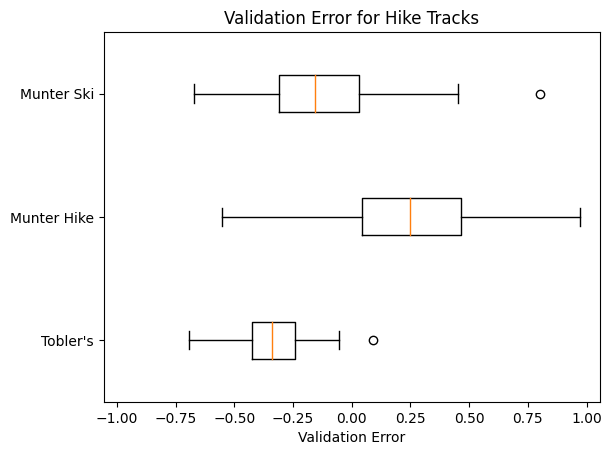

In [245]:
plot_errors_for_data(tracks_by_type[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ],
    ["Tobler's", "Munter Hike", "Munter Ski"],
                    "Validation Error for Hike Tracks")
plt.show()

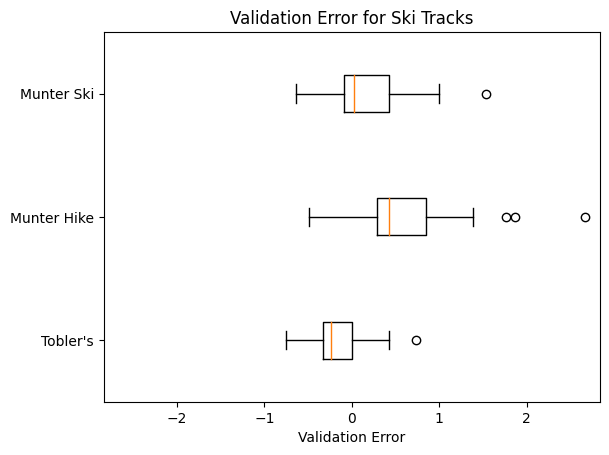

In [246]:
plot_errors_for_data(tracks_by_type[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ],
    ["Tobler's", "Munter Hike", "Munter Ski"],
                    "Validation Error for Ski Tracks")
plt.show()

Conclusions: 
Toblers method results in errors that cluster closer together, but seems to predict paces that are a bit too fast. 
Munter's Methid for Skiing appears pretty good, but toblers method is also really good! Why? Uphill times matter far more than downhill times. It doesn't actually matter that much if our downhill times are radically wrong if our uphill times are good!

Where is our room for improvement: 
1. We should try to just predict moving time, not time taken during long breaks 
2. We should try to fit the parameters to our data, in particular both the munter and toblers functions have parameters we can and should change to match our conditions.
3. We should investigate other functions to see if we can do better with a similar or slightly higher number of parameters. 

# Removing Breaks from our Tracks

Observe: There is a massive variable in our pace data that is comprised of taking breaks! The time taken as a break depoends far more on factors like view, weather, and company, than other factors. We should in theory get more accurate predictions if we restrict our goal to predicting time taken with no breaks. 

We will relax our no-break rule a bit though, because short breaks do matter for pace! If you sprint uphill and have to take a few minutes of rest to get your shit back together, then removing that break makes you look way faster than you are. 

We will define a break as any part of our track where we go under some threshold speed and stay under that threshold speed for some amount of time. We will set the threshold speed very low, and the threshold duration at something like 10 minutes. Short breaks are always included!

In [247]:
def plot_elevation_vs_time(tracks, colors=None):
    # Prepare data
    first_time = None
    lines = []
    for track_idx, track in enumerate(tracks):
        elevations = []
        times = []
        segment = track.segments[0]  # Assume each track has only one segment
        for point in segment.points:
            elevations.append(point.elevation)
            # Convert time values to naive datetime objects
            current_time = point.time.replace(tzinfo=None)

            if not first_time:
                first_time = current_time
                
            # Calculate cumulative time in minutes
            time_delta = (current_time - first_time).total_seconds() / 60
            times.append(time_delta)
        lines.append((times, elevations))

    # Create plot with wider figsize (width=12, height=6)
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Elevation vs Time")
    ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Elevation (m)")

    # Plot lines with given colors
    for i, line_data in enumerate(lines):
        times, elevations = line_data
        color = colors[i] if colors is not None and len(colors) > i else None
        ax.plot(times, elevations, color=color)

    # Show plot
    plt.show()

In [248]:
# Chosing a hike track by name
print([(idx, t.name) for (idx, t) in enumerate(tracks_by_type[ACTIVITY_HIKE])])

[(0, 'September turns '), (1, 'Lunch Hike'), (2, 'Evening Hike'), (3, 'Afternoon Hike'), (4, 'Star + Courtney + Oval'), (5, 'Evening dentist appointment '), (6, 'Hike to burroughs mountain'), (7, 'DC attempt'), (8, 'Olympics hike with Mom '), (9, 'TH to Muir'), (10, 'Del Campo Sunset Scramble'), (11, 'Mesachie Scramble'), (12, 'Easton C2C'), (13, 'Snow lake to Little Annapurna Summit and Back'), (14, 'Little Bandera and Mason Lake'), (15, 'Trailhead to snow lake '), (16, 'Muir!'), (17, 'Glacier Peak Day 1'), (18, 'Morning Hike'), (19, 'Kaleetan Peak Scramble'), (20, 'Stuart West Ridge '), (21, 'Cougar, Gifford Pinchot National Forest'), (22, 'Afternoon Hike'), (23, 'Glacier Peak Day 2'), (24, 'Lake Valhalla '), (25, 'Morning Hike'), (26, 'Snow lake back to trailhead '), (27, 'Glacier Peak Day 3'), (28, 'Robinson Mountain Hike'), (29, 'Muir back to TH '), (30, 'Mt. St. Helens Hike'), (31, 'Prusik peak'), (32, 'Liberty bell and Concord tower ')]


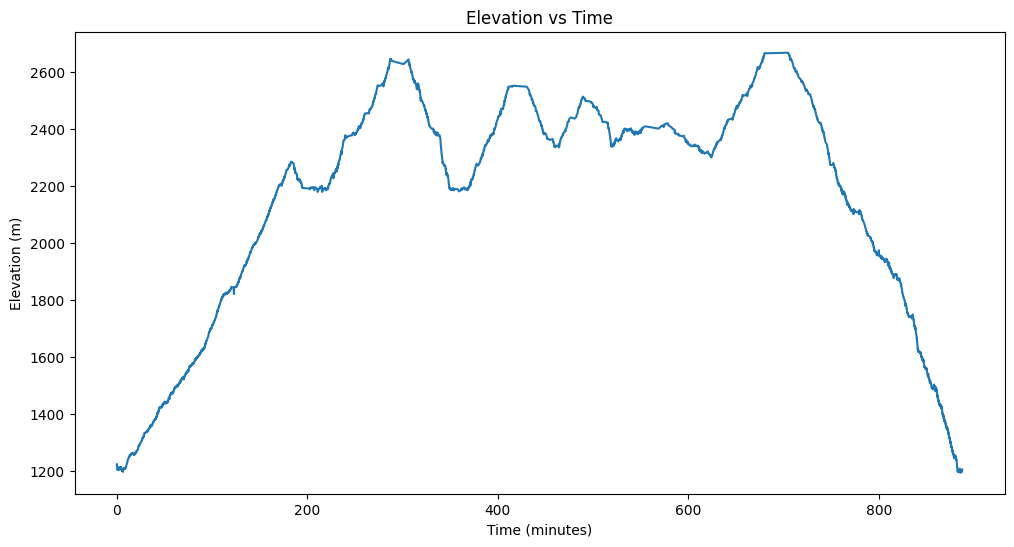

In [249]:
# this particular hike is known as the wish slam
wish_slam_original = tracks_by_type[ACTIVITY_HIKE][4]
plot_elevation_vs_time([wish_slam_original])

In [250]:
def expandBreaks(breaks, distanceDeltas, timeDeltas, direction, pacethresh):
    # Expand breaks either left or right depending on direction
    newBreaks = []
    for currBreak in breaks:
        (startIdx, endIdx, distance, time) = currBreak

        newIdx = startIdx - 1 if direction == -1 else endIdx
        newStartIdx = startIdx - 1 if direction == -1 else startIdx
        newEndIdx = endIdx + 1 if direction == 1 else endIdx

        if (newIdx < 0 or newIdx >= len(distanceDeltas)):
            newBreaks.append(currBreak)
            continue  # Can't expand this break in this direction, hit end

        newTime = timeDeltas[newIdx] + time
        newDistance = distanceDeltas[newIdx] + distance

        newPace = newDistance / newTime
        if (newPace < pacethresh):
            newBreaks.append((newStartIdx, newEndIdx, newDistance, newTime))
        else:
            newBreaks.append(currBreak)
    return newBreaks


def mergeBreaks(breaks, pacethresh):
    # Merge breaks that are adjacent. We can do this because if the average
    # pace for two adjacent breaks is under the threshold, the combined
    # pace must be as well.
    mergedBreaks = [breaks[0]]
    for currentBreak in breaks[1:]:
        (prevStartIdx, prevEndIdx, prevDist, prevTime) = mergedBreaks[-1]
        (currStartIdx, currEndIdx, currDist, currTime) = currentBreak

        canMerge = prevEndIdx == currStartIdx and (
            (currDist + prevDist)/(currTime + prevTime)) < pacethresh

        if (canMerge):
            mergedBreaks.pop()
            mergedBreaks.append((prevStartIdx, currEndIdx, prevDist +
                                 currDist, prevTime + currTime))
        else:
            mergedBreaks.append(currentBreak)
    return mergedBreaks


def find_breaks(points, distancefunc, timefunc, pacethresh):
    # points are an array or other iterable of arbitrary point objects
    # distancefunc accepts two points and returns a float distance between them
    # timefunc accepts two points and returns the elapsed time between them

    # distancedeltas[i] is the distance between points[i] and points[i+1]
    distancedeltas = []
    for i in range(len(points)-1):
        distancedeltas.append(distancefunc(points[i], points[i+1]))

    # timedeltas[i] is the time between points[i] and points[i+1]
    timedeltas = []
    for i in range(len(points)-1):
        timedeltas.append(timefunc(points[i], points[i+1]))

    # paces[i] is the pace between points[i] and points[i+1]
    paces = []
    for i in range(len(points)-1):
        paces.append(distancedeltas[i]/timedeltas[i])

    # Breaks consists of tuple elements (startindex, endindex, distance, time)
    # They are ordered and non-overlapping ([(1, 3, x, y), (2, 5, p, q)] is
    # invalid).
    # Breaks starts with all the length one segments where pace is momentarily
    # below the threshold.
    breaks = []
    for idx, pace in enumerate(paces):
        if (pace < pacethresh):
            breaks.append((idx, idx+1, distancedeltas[idx], timedeltas[idx]))

    # We want breaks to contain all segments of the points where the average
    # pace for traversing all points in the segment is below the threshold.
    # We find these by expanding and merging the 'seed' breaks.

    lastBreaks = []   # We want an early return if no breaks were found
    while (lastBreaks != breaks):
        lastBreaks = breaks

        # Attempt to expand the breaks both left and right, with a merge in
        # between to avoid break bounds running over eachother.
        breaks = mergeBreaks(breaks, pacethresh)
        breaks = expandBreaks(breaks, distancedeltas,
                              timedeltas, -1, pacethresh)
        breaks = mergeBreaks(breaks, pacethresh)
        breaks = expandBreaks(breaks, distancedeltas,
                              timedeltas, 1, pacethresh)

    # cycle of expanding and merging breaks has not changed the breaks at all
    # thus these are our final answer
    return breaks

# Distance and time funcs for above break removal


def break_timefunc(point1, point2):
    time_delta = point2.time - point1.time
    return time_delta.total_seconds()


def break_distancefunc(point1, point2):
    return distance(point1.longitude, point1.latitude, point2.longitude, point2.latitude)


def breaks_over_duration(breaks, duration_thresh):
    return [(i, j, x, d) for (i, j, x, d) in breaks if d > duration_thresh]


def remove_breaks_from_points(points, breaks):

    if (len(breaks) == 0):
        return points

    newPoints = []

    (first_break_idx, _, _, _) = breaks[0]
    newPoints += points[0:first_break_idx+1]

    for idx in range(0, len(breaks)):
        # Break start idx already added to the newPoints
        (break_start_idx, break_end_idx, _, _) = breaks[idx]
        
        if(idx < len(breaks) - 1):
            (next_break_start_idx, _, _, _) = breaks[idx+1]
        else:
            next_break_start_idx = len(points)

        # Time delta over the course of the break
        # Use this instead of summing the individual deltas to avoid rounding errors
        realized_time_delta_seconds = break_timefunc(
            points[break_start_idx], points[break_end_idx])
        realized_time_delta = timedelta(seconds=realized_time_delta_seconds)

        # Adjust the time of all points following the break
        for idx in range(break_end_idx, len(points)):
            points[idx].time -= realized_time_delta

        # Chunk of points to move
        moved_points = points[break_end_idx:next_break_start_idx+1]

        newPoints += moved_points

    assert (not do_points_timetravel(newPoints))

    return newPoints

def remove_breaks_from_track(track, breaks):
    track.segments[0].points = remove_breaks_from_points(
        track.segments[0].points, breaks)

def do_points_timetravel(points):
    previous_time = None
    for point in points:
        if previous_time is not None and point.time < previous_time:
            return True
        previous_time = point.time
    return False

def remove_identical_time_points(points, timefunc):
    # Utility, our points may contain pairs of points that have the same time.
    # i.e. timefunc(points[i], points[i+1]) == 0
    # This causes problems for our calculations because the pace between such points is undefined. 
    # This utility finds such pairs of points and removes the second point in each offending pair
    # It returns the cleaned up points
    
    cleaned_points = [points[0]]
    
    for point in points[1:]:
        if(timefunc(cleaned_points[-1], point) > 0):
            cleaned_points.append(point)
            
    return cleaned_points

def find_and_remove_breaks_from_track(track, break_length, speed_threshold):
    breaks = find_breaks(track.segments[0].points,
                         break_distancefunc, break_timefunc, speed_threshold)

    breaks = breaks_over_duration(breaks, break_length)

    remove_breaks_from_track(track, breaks)
    
def copy_find_remove_breaks_from_track(track, break_length, speed_threshold):
    newTrack = track.clone()
    newTrack.segments[0].points = remove_identical_time_points(newTrack.segments[0].points, break_timefunc)
    find_and_remove_breaks_from_track(newTrack, break_length, speed_threshold)
    return newTrack
    

In [251]:
break_threshold_pace = 0.03
break_threshold_time = 500 # five minutes

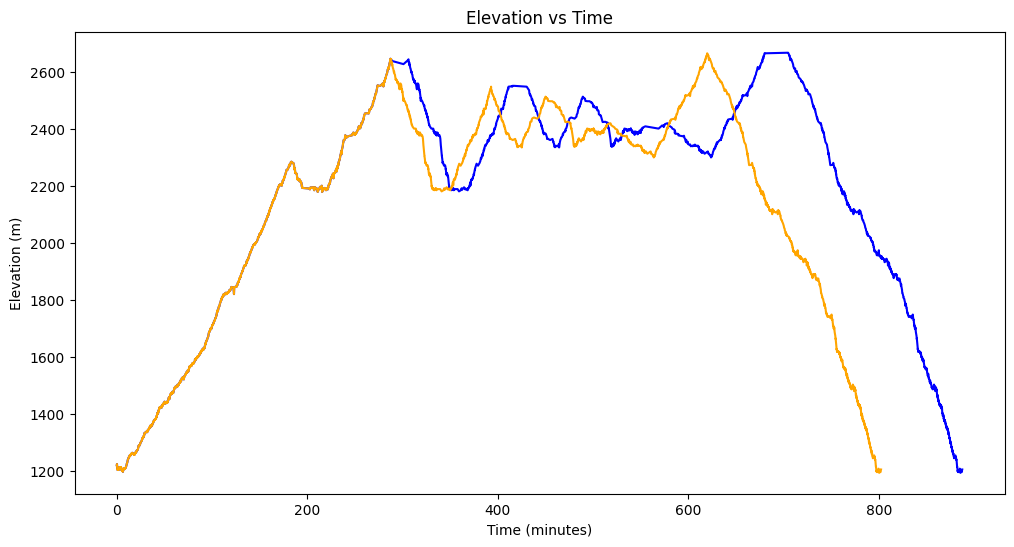

In [252]:
# this particular hike is known as the wish slam
wish_slam_trimmed = copy_find_remove_breaks_from_track(wish_slam_original, break_threshold_time, break_threshold_pace)
plot_elevation_vs_time([wish_slam_original, wish_slam_trimmed], colors=["blue", "Orange"])

In [253]:
def duration(track):
    points = track.segments[0].points
    delta_seconds = (points[-1].time - points[0].time).total_seconds()
    return timedelta(seconds=delta_seconds)

td = duration(wish_slam_trimmed)

# format the timedelta object as h:m:s string
hours, remainder = divmod(td.seconds, 3600)
minutes, seconds = divmod(remainder, 60)
time_str = '{:02d}:{:02d}:{:02d}'.format(hours, minutes, seconds)

# print the formatted string
print('Duration: {}'.format(time_str))

Duration: 13:22:10


In [254]:
tracks_by_type_trimmed = {}
for (tracktype, tracks) in tracks_by_type.items():
    trimmed_tracks = [copy_find_remove_breaks_from_track(track, break_threshold_time, break_threshold_pace) for track in tracks]
    tracks_by_type_trimmed[tracktype] = trimmed_tracks

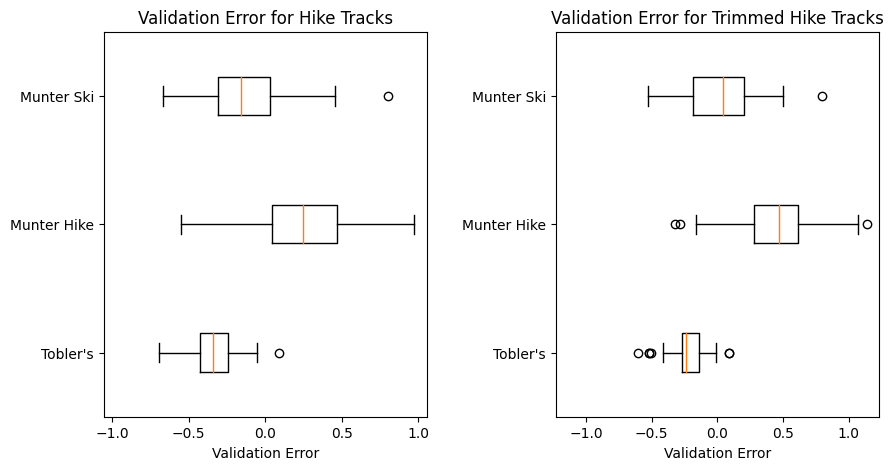

Error data for hike tracks: Raw Markdown
pacefunc       min error    25th percentile error    50th percentile error    75th percentile error    max error       IQR
-----------  -----------  -----------------------  -----------------------  -----------------------  -----------  --------
Tobler's       -0.6946                 -0.42312                  -0.341471               -0.241053     0.0923743  0.182067
Munter Hike    -0.551169                0.0422448                 0.249435                0.466705     0.972652   0.424461
Munter Ski     -0.6707                 -0.310926                 -0.157491                0.0320515    0.800865   0.342978
Error data for hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.6946,-0.42312,-0.341471,-0.241053,0.0923743,0.182067
Munter Hike,-0.551169,0.0422448,0.249435,0.466705,0.972652,0.424461
Munter Ski,-0.6707,-0.310926,-0.157491,0.0320515,0.800865,0.342978


Error data for trimmed hike tracks: Raw Markdown
pacefunc       min error    25th percentile error    50th percentile error    75th percentile error    max error       IQR
-----------  -----------  -----------------------  -----------------------  -----------------------  -----------  --------
Tobler's       -0.600868                -0.269406                -0.236858                -0.140485    0.0923743  0.128921
Munter Hike    -0.323727                 0.28344                  0.466705                 0.617929    1.14304    0.334489
Munter Ski     -0.526672                -0.188644                 0.04643                  0.203042    0.800865   0.391685
Error data for trimmed hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.600868,-0.269406,-0.236858,-0.140485,0.0923743,0.128921
Munter Hike,-0.323727,0.28344,0.466705,0.617929,1.14304,0.334489
Munter Ski,-0.526672,-0.188644,0.04643,0.203042,0.800865,0.391685


In [255]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

hike_errors = get_errors_for_data(tracks_by_type[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ])

pacefunc_labels = ["Tobler's", "Munter Hike", "Munter Ski"]

plot_errors(hike_errors,
            pacefunc_labels,
            "Validation Error for Hike Tracks",
            ax=axs[0])

hike_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ])

plot_errors(hike_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Hike Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

print("Error data for hike tracks: Raw Markdown")
print(boxplot_stats_table(
        hike_errors,
        pacefunc_labels,
        md=True
    ))

print("Error data for hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed hike tracks: Raw Markdown")
print(boxplot_stats_table(
        hike_errors_trimmed,
        pacefunc_labels,
        md=True
    ))

print("Error data for trimmed hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors_trimmed,
        pacefunc_labels,
    )
))

Observe: 

IQR improved for toblers and munter hike. Munter ski IQR is worse slightly. 
50th percentile predictions improved a lot for toblers method, but got worse for munter hike.

Conclusions: Since we will later try to fit our parameters to account for bias, we mostly care about the IQR here. How well do the errors cluster? 

Toblers comes out looking very trustworthy for estimating moving time. If you're moving continuously and have a good idea about the frequency and length of your breaks. Standard toblers is my strong recomendation.

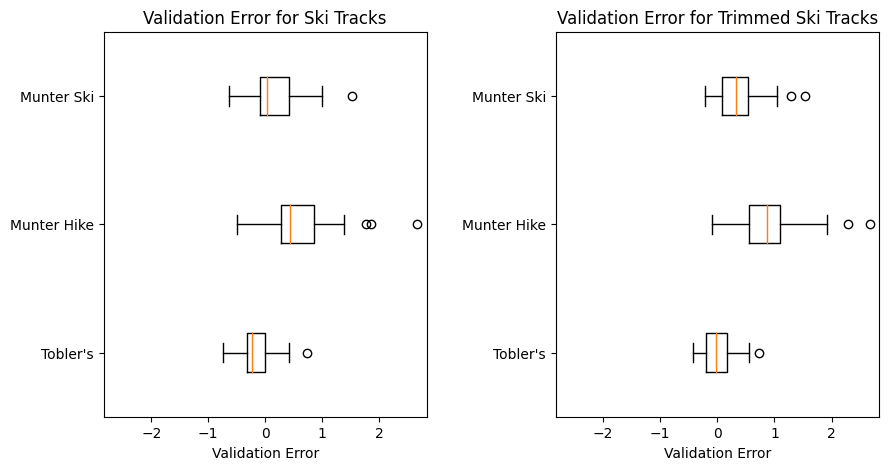

Error data for ski tracks: Raw Markdown
pacefunc       min error    25th percentile error    50th percentile error    75th percentile error    max error       IQR
-----------  -----------  -----------------------  -----------------------  -----------------------  -----------  --------
Tobler's       -0.747568               -0.326341                -0.232423                0.00327991      0.73554  0.32962
Munter Hike    -0.488748                0.285369                 0.428108                0.85386         2.66589  0.568492
Munter Ski     -0.639719               -0.0869261                0.0297901               0.422645        1.53325  0.509571
Error data for ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.747568,-0.326341,-0.232423,0.00327991,0.73554,0.32962
Munter Hike,-0.488748,0.285369,0.428108,0.85386,2.66589,0.568492
Munter Ski,-0.639719,-0.0869261,0.0297901,0.422645,1.53325,0.509571


Error data for trimmed ski tracks: Raw Markdown
pacefunc       min error    25th percentile error    50th percentile error    75th percentile error    max error       IQR
-----------  -----------  -----------------------  -----------------------  -----------------------  -----------  --------
Tobler's      -0.424186                -0.196397                -0.0205109                 0.175277     0.736631  0.371674
Munter Hike   -0.0999253                0.562524                 0.876581                  1.10227      2.66774   0.539746
Munter Ski    -0.216255                 0.0814588                0.325991                  0.536884     1.53483   0.455426
Error data for trimmed ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.424186,-0.196397,-0.0205109,0.175277,0.736631,0.371674
Munter Hike,-0.0999253,0.562524,0.876581,1.10227,2.66774,0.539746
Munter Ski,-0.216255,0.0814588,0.325991,0.536884,1.53483,0.455426


In [256]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

ski_errors = get_errors_for_data(tracks_by_type[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ])

pacefunc_labels = ["Tobler's", "Munter Hike", "Munter Ski"]

plot_errors(ski_errors,
            pacefunc_labels,
            "Validation Error for Ski Tracks",
            ax=axs[0])

ski_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10)
    ])

plot_errors(ski_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Ski Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

print("Error data for ski tracks: Raw Markdown")
print(boxplot_stats_table(
        ski_errors,
        pacefunc_labels,
        md=True
    ))

print("Error data for ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed ski tracks: Raw Markdown")
print(boxplot_stats_table(
        ski_errors_trimmed,
        pacefunc_labels,
        md=True
    ))

print("Error data for trimmed ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors_trimmed,
        pacefunc_labels,
    )
))

In [257]:
pace_data_trimmed = get_grade_pace_data_for_trackset(tracks_by_type_trimmed)

Conclusions are far less clear for ski data. Operating on the trimmed tracks doesn't seem to have given any of our pace functions a real leg up. 

When it comes to making a decision about using one of these pace functions to predict moving time vs total time, it's clear that estimates are less reliable than with hiking. 

Given that our IQRs didn't get consistently better or worse, and not by much. I am going to continue using the trimmed tracks for further analysis. I have a hunch that this is a better practice since it is demonstrably more robust in the hiking scenarios. For skiing, it's possible that my tracks just don't have as many long breaks to remove.



# Curve fitting, How much better can we do? 

## Simple Approach: Raw Tracks

In [258]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data[ACTIVITY_HIKE][:, 0], pace_data[ACTIVITY_HIKE][:, 1], p0=[6, -3.4, 0.05])
print("Fit results for toblers with hike data:")
print(res)

params = res[0]
toblers_hike_fitted = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with hike data:
(array([ 4.73027724, -2.11840484,  0.055364  ]), array([[ 1.23452814e-03, -1.38126658e-03, -2.46332496e-06],
       [-1.38126658e-03,  2.74528897e-03,  2.10327060e-05],
       [-2.46332496e-06,  2.10327060e-05,  5.53425473e-06]]))


In [259]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data[ACTIVITY_SKI][:, 0], pace_data[ACTIVITY_SKI][:, 1])
print("Fit results for toblers with ski data:")
print(res)

params = res[0]
toblers_ski_fitted = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with ski data:
(array([20.4996423 , -4.27870876,  0.24438172]), array([[ 6.64062031e-02, -1.51627546e-02,  5.22704871e-05],
       [-1.51627546e-02,  7.45633536e-03,  4.88040934e-05],
       [ 5.22704871e-05,  4.88040934e-05,  4.94297176e-06]]))


In [260]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data[ACTIVITY_HIKE][:, 0], pace_data[ACTIVITY_HIKE][:, 1], p0=[4,6,4])
print("Fit results for munter with hike data:")
print(res)

params = res[0]
munter_hike_fitted = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with hike data:
(array([8.82816883, 4.11041911, 7.28528651]), array([[0.00458535, 0.        , 0.        ],
       [0.        , 0.00150811, 0.        ],
       [0.        , 0.        , 0.00453869]]))


In [261]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data[ACTIVITY_SKI][:, 0], pace_data[ACTIVITY_SKI][:, 1], p0=[10,6,4])
print("Fit results for munter with ski data:")
print(res)

params = res[0]
munter_ski_fitted = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with ski data:
(array([33.23039805,  5.95908016,  6.68554549]), array([[0.13191151, 0.        , 0.        ],
       [0.        , 0.06310923, 0.        ],
       [0.        , 0.        , 0.11677759]]))


## Simple Approach: Trimmed Tracks

In [262]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_trimmed[ACTIVITY_HIKE][:, 0], pace_data_trimmed[ACTIVITY_HIKE][:, 1], p0=[6, -3.4, 0.05])
print("Fit results for toblers with hike data:")
print(res)

params = res[0]
toblers_hike_fitted_trimmed = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with hike data:
(array([ 4.75864462, -2.04768276,  0.05520932]), array([[ 1.20796484e-03, -1.33211442e-03, -2.78904255e-06],
       [-1.33211442e-03,  2.60477890e-03,  2.10466514e-05],
       [-2.78904255e-06,  2.10466514e-05,  5.71721653e-06]]))


In [263]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_trimmed[ACTIVITY_SKI][:, 0], pace_data_trimmed[ACTIVITY_SKI][:, 1])
print("Fit results for toblers with ski data:")
print(res)

params = res[0]
toblers_ski_fitted_trimmed = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with ski data:
(array([20.70298421, -4.19155951,  0.24727555]), array([[ 6.58912088e-02, -1.46983675e-02,  4.51193815e-05],
       [-1.46983675e-02,  7.09223488e-03,  5.12705326e-05],
       [ 4.51193815e-05,  5.12705326e-05,  5.07544101e-06]]))


In [264]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_trimmed[ACTIVITY_HIKE][:, 0], pace_data_trimmed[ACTIVITY_HIKE][:, 1], p0=[4,6,4])
print("Fit results for munter with hike data:")
print(res)

params = res[0]
munter_hike_fitted_trimmed = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with hike data:
(array([8.91062242, 4.15732901, 7.43211121]), array([[0.0045231 , 0.        , 0.        ],
       [0.        , 0.00150984, 0.        ],
       [0.        , 0.        , 0.00455546]]))


In [265]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_trimmed[ACTIVITY_SKI][:, 0], pace_data_trimmed[ACTIVITY_SKI][:, 1], p0=[10,6,4])
print("Fit results for munter with ski data:")
print(res)

params = res[0]
munter_ski_fitted_trimmed = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with ski data:
(array([33.68173417,  6.12340594,  6.96602765]), array([[0.13220047, 0.        , 0.        ],
       [0.        , 0.06561763, 0.        ],
       [0.        , 0.        , 0.11741532]]))


## Analysis

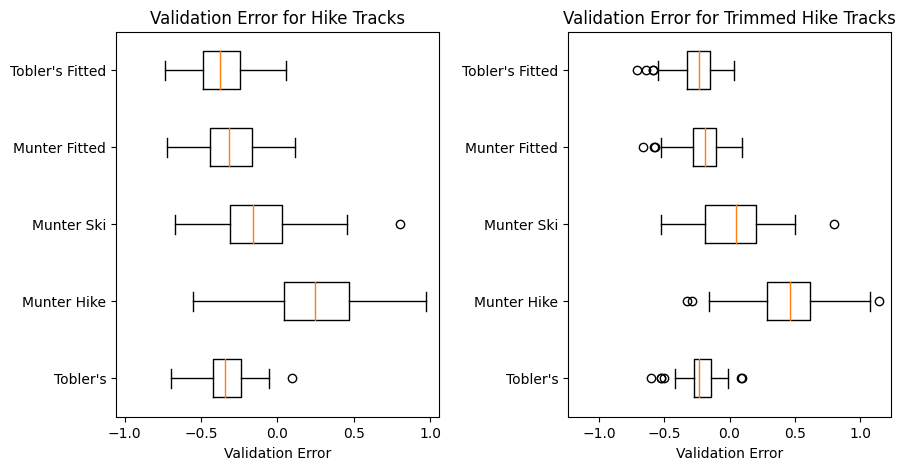

Error data for hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.6946,-0.42312,-0.341471,-0.241053,0.0923743,0.182067
Munter Hike,-0.551169,0.0422448,0.249435,0.466705,0.972652,0.424461
Munter Ski,-0.6707,-0.310926,-0.157491,0.0320515,0.800865,0.342978
Munter Fitted,-0.726976,-0.440981,-0.316653,-0.167775,0.116601,0.273206
Tobler's Fitted,-0.736948,-0.486075,-0.375976,-0.24612,0.0555632,0.239955


Error data for trimmed hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.600868,-0.269406,-0.236858,-0.140485,0.0923743,0.128921
Munter Hike,-0.323727,0.28344,0.466705,0.617929,1.14304,0.334489
Munter Ski,-0.526672,-0.188644,0.04643,0.203042,0.800865,0.391685
Munter Fitted,-0.660149,-0.276131,-0.189681,-0.100491,0.0967329,0.17564
Tobler's Fitted,-0.709703,-0.324783,-0.231839,-0.152142,0.0332334,0.172641


In [266]:
# Analysis, how much better did we do with fitting for Hike tracks? 

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

hike_errors = get_errors_for_data(tracks_by_type[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_hike_fitted, 
     toblers_hike_fitted,
    ])

pacefunc_labels = ["Tobler's", 
                   "Munter Hike", 
                   "Munter Ski", 
                   "Munter Fitted", 
                   "Tobler's Fitted"
                  ]

plot_errors(hike_errors,
            pacefunc_labels,
            "Validation Error for Hike Tracks",
            ax=axs[0])

hike_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_hike_fitted_trimmed, 
     toblers_hike_fitted_trimmed,
    ])

plot_errors(hike_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Hike Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

print("Error data for hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors_trimmed,
        pacefunc_labels,
    )
))

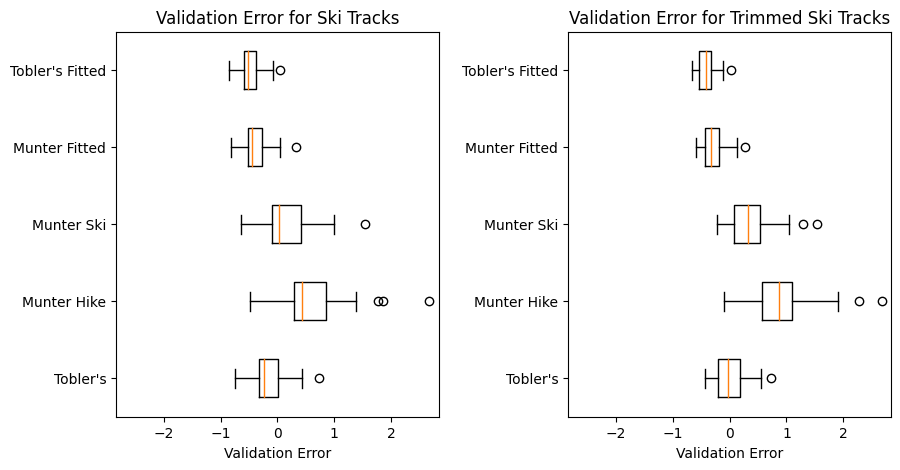

Error data for ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.747568,-0.326341,-0.232423,0.00327991,0.73554,0.32962
Munter Hike,-0.488748,0.285369,0.428108,0.85386,2.66589,0.568492
Munter Ski,-0.639719,-0.0869261,0.0297901,0.422645,1.53325,0.509571
Munter Fitted,-0.808608,-0.512957,-0.442144,-0.276678,0.318278,0.236279
Tobler's Fitted,-0.847964,-0.586447,-0.516159,-0.383246,0.0512875,0.203201


Error data for trimmed ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.424186,-0.196397,-0.0205109,0.175277,0.736631,0.371674
Munter Hike,-0.0999253,0.562524,0.876581,1.10227,2.66774,0.539746
Munter Ski,-0.216255,0.0814588,0.325991,0.536884,1.53483,0.455426
Munter Fitted,-0.588557,-0.425957,-0.31857,-0.183625,0.273054,0.242333
Tobler's Fitted,-0.653216,-0.532362,-0.41663,-0.325811,0.0173239,0.206552


In [267]:
# Analysis, how much better did we do with fitting for Ski tracks? 

fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

ski_errors = get_errors_for_data(tracks_by_type[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_ski_fitted, 
     toblers_ski_fitted,
    ])

pacefunc_labels = ["Tobler's", 
                   "Munter Hike", 
                   "Munter Ski", 
                   "Munter Fitted", 
                   "Tobler's Fitted"
                  ]

plot_errors(ski_errors,
            pacefunc_labels,
            "Validation Error for Ski Tracks",
            ax=axs[0])

ski_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_ski_fitted_trimmed, 
     toblers_ski_fitted_trimmed,
    ])

plot_errors(ski_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Ski Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()

print("Error data for ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors_trimmed,
        pacefunc_labels,
    )
))

# Resampling

What do we actually want? We want to apply a function to individual chunks and get our result out the other end, but we want to do our fitting such that long breaks are considered in our fitting process... 

The problem with our previous approach is that a handful of points with very low rates matter much more than others in our final output. What matters in the end is time, not distance. A break that takes 10 minutes should matter much more than a sprint that only takes a few seconds, but covers a lot of ground! 

Extreme example: You are an extremely fast sprinter and can sprint 20m/s but you need to break 10 minutes after each 200m sprint, during your break, you walk at normal speed for 50m. When I break your track into 50m chunks, 4/5 of the data points will be sprinting data points, and if I do a regression on these points, I will conclude that you move at 20 m/s, but the breaks are extremely important!

The presence of any running at all absolutly poisons the dataset, unless I can run the entire time!

Solutions (for better fitting existing methods):
- data needs to be broken up by time, not by distance, or, if by distance, needs to be broken up over much longer distances where more chunks will contain breaks. 
- weight the regression so chunks that take lots of time are counted more, sort of statistics voodoo, come at me stats bros!
- just try and optimize the whole problem, not for individual chunks. Take a track and tune the parameters to get minimum loss with some generic search strategy. See how close we can get. 

Ideas for better modeling: 
- Future models should create a statistical distribution from which a rate is taken, with non zero weight on no speed at all
- Future models should put a little bit of break into every segment, under estimating most!

## Experiment: use statistical resampling to get better results

In [268]:
trackdata = pace_data_for_tracks([wish_slam_original])
# Same track as before, nice and long so lots of points

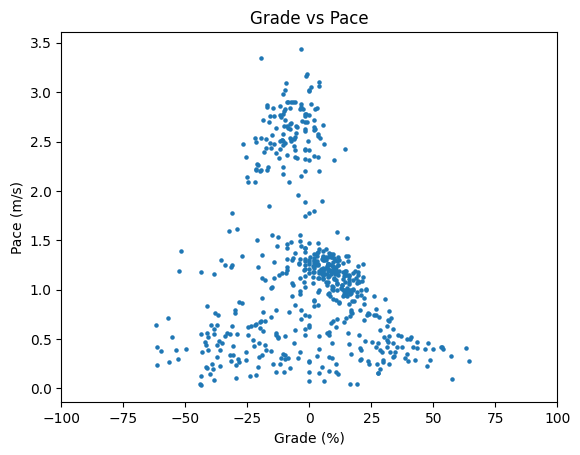

In [269]:
scatter_plot_grade_and_pace_data(trackdata, xlimits=[-100,100])

In [270]:
def resample_by_time(data, numsamples):
    # Extract duration column from data
    duration = data[:, 2]
    
    # Compute total duration
    total_duration = np.sum(duration)
    
    # Compute the probability of selecting each data point
    prob = duration / total_duration
    
    # Resample data by selecting indices according to their probability
    indices = np.random.choice(np.arange(len(data)), size=numsamples, p=prob)
    
    # Select corresponding rows from data
    resampled_data = data[indices]
    
    return resampled_data

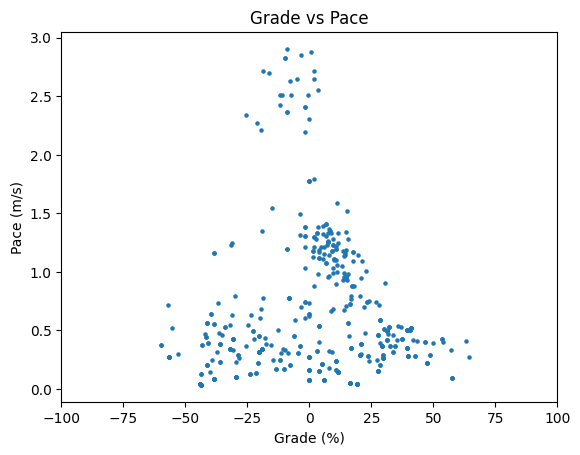

In [271]:
resampled_data = resample_by_time(trackdata, 500)
scatter_plot_grade_and_pace_data(resampled_data, xlimits=[-100,100])

In [272]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, trackdata[:, 0], trackdata[:, 1], p0=[6, -3.4, 0.05])
print(res)

params = res[0]
original_fit = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

(array([ 7.50528121, -3.52524414,  0.07612266]), array([[ 5.67353572e-02, -4.40227967e-02,  9.76261661e-05],
       [-4.40227967e-02,  6.23243168e-02,  2.31174805e-04],
       [ 9.76261661e-05,  2.31174805e-04,  3.74827630e-05]]))


In [273]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, resampled_data[:, 0], resampled_data[:, 1], p0=[6, -3.4, 0.05])
print(res)

params = res[0]
resampled_fit = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

(array([ 4.43535871, -3.4793333 ,  0.04894635]), array([[ 6.82925106e-02, -7.04205665e-02,  8.31802351e-04],
       [-7.04205665e-02,  1.27490990e-01, -2.31972388e-04],
       [ 8.31802351e-04, -2.31972388e-04,  1.23877474e-04]]))


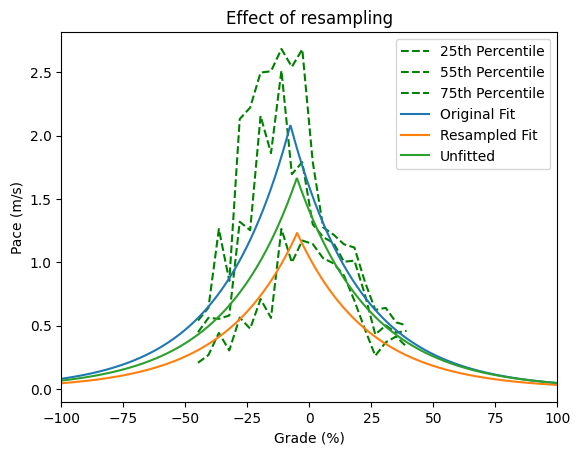

In [274]:
plot_data_percentiles_and_pacefuncs(trackdata, 
                                   [original_fit, 
                                       resampled_fit, 
                                   toblers_hiking_pace_standard], 
                                    ["Original Fit", "Resampled Fit", "Unfitted"],
                                   title="Effect of resampling")

In [275]:
display(HTML(
check_validation_error(
    [trackdata], 
    ["Track"], 
    [toblers_hiking_pace_standard, 
original_fit, 
     resampled_fit
    ],
    ["Tobler's", "Fitted to raw data", "Fitted to resampled data"]
)
))

Dataset,Tobler's,Fitted to raw data,Fitted to resampled data
Track,0.243532,0.355954,-0.0427885


## Resampling all the data

In [276]:
def resample_pace_data_by_type(pace_data_by_type, sample_mul):
    resampled_data = {}
    for tracktype, data in pace_data_by_type.items():
        resampled_data[tracktype] = resample_by_time(data, sample_mul * len(data))
    return resampled_data

In [277]:
# Chose 5x more points, this is overkill, but ensures that our resampling is robust
pace_data_resampled = resample_pace_data_by_type(pace_data, 5)
pace_data_trimmed_resampled = resample_pace_data_by_type(pace_data_trimmed, 5)

TODO: Show side by side figures here, to make this more clear!

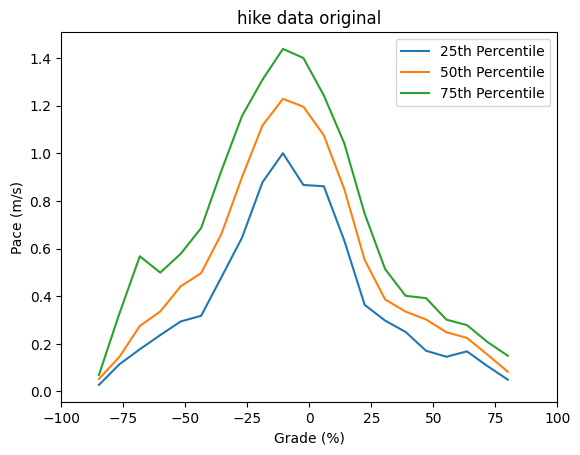

In [278]:
plot_grade_and_pace_percentiles(pace_data[ACTIVITY_HIKE], title="hike data original", binning=30, xlimits=[-100,100])

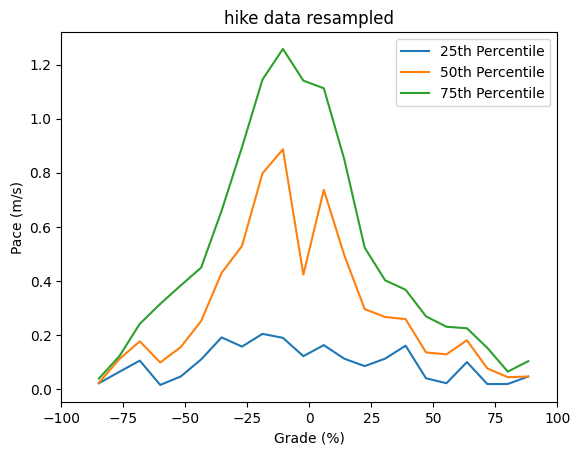

In [279]:
plot_grade_and_pace_percentiles(pace_data_resampled[ACTIVITY_HIKE], title="hike data resampled", binning=30, xlimits=[-100,100])

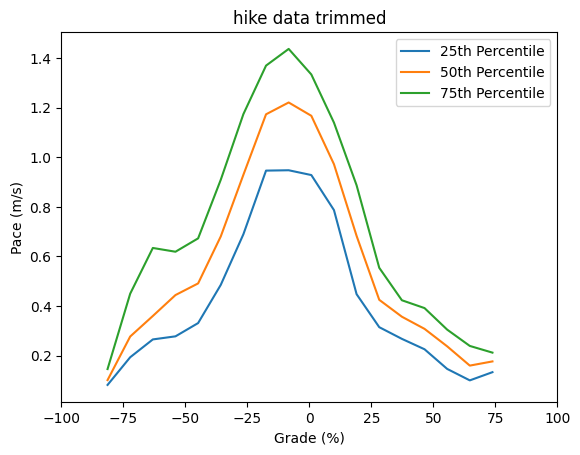

In [280]:
plot_grade_and_pace_percentiles(pace_data_trimmed[ACTIVITY_HIKE], title="hike data trimmed", binning=30, xlimits=[-100,100])

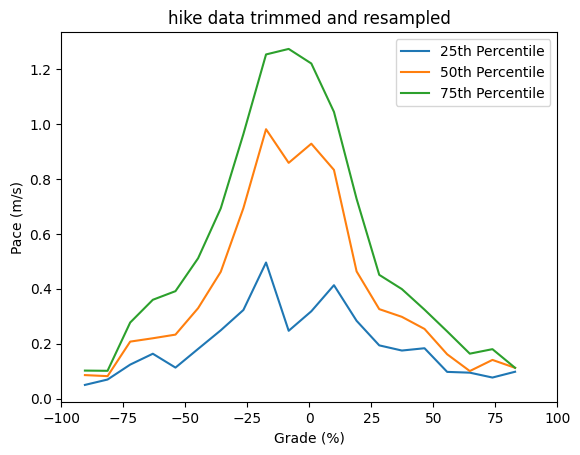

In [281]:
plot_grade_and_pace_percentiles(pace_data_trimmed_resampled[ACTIVITY_HIKE], title="hike data trimmed and resampled", binning=30, xlimits=[-100,100])

## Fitting the resampled data

## resampled Approach: Raw Tracks

In [282]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_resampled[ACTIVITY_HIKE][:, 0], pace_data_resampled[ACTIVITY_HIKE][:, 1], p0=[6, -3.4, 0.05])
print("Fit results for toblers with hike data:")
print(res)

params = res[0]
toblers_hike_fitted_resampled = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with hike data:
(array([ 3.04041708, -2.40726643,  0.0670953 ]), array([[ 3.06660262e-04, -4.21262262e-04,  2.30798154e-06],
       [-4.21262262e-04,  1.08733061e-03,  5.95175132e-06],
       [ 2.30798154e-06,  5.95175132e-06,  2.71065720e-06]]))


In [283]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_resampled[ACTIVITY_SKI][:, 0], pace_data_resampled[ACTIVITY_SKI][:, 1])
print("Fit results for toblers with ski data:")
print(res)

params = res[0]
toblers_ski_fitted_resampled = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with ski data:
(array([ 4.42042598, -2.10662485,  0.32351981]), array([[ 4.05973553e-03, -1.78264658e-03,  1.09545409e-04],
       [-1.78264658e-03,  1.96252382e-03,  8.44908759e-05],
       [ 1.09545409e-04,  8.44908759e-05,  3.17807480e-05]]))


In [284]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_resampled[ACTIVITY_HIKE][:, 0], pace_data_resampled[ACTIVITY_HIKE][:, 1], p0=[4,6,4])
print("Fit results for munter with hike data:")
print(res)

params = res[0]
munter_hike_fitted_resampled = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with hike data:
(array([5.70050736, 2.35215931, 4.75032886]), array([[0.00114495, 0.        , 0.        ],
       [0.        , 0.00036095, 0.        ],
       [0.        , 0.        , 0.00094368]]))


In [285]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_resampled[ACTIVITY_SKI][:, 0], pace_data_resampled[ACTIVITY_SKI][:, 1], p0=[10,6,4])
print("Fit results for munter with ski data:")
print(res)

params = res[0]
munter_ski_fitted_resampled = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with ski data:
(array([7.07730346, 1.78202463, 4.05636296]), array([[0.00718226, 0.        , 0.        ],
       [0.        , 0.0021748 , 0.        ],
       [0.        , 0.        , 0.00367677]]))


## resampled approach: Trimmed Tracks

In [286]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_trimmed_resampled[ACTIVITY_HIKE][:, 0], pace_data_trimmed_resampled[ACTIVITY_HIKE][:, 1], p0=[6, -3.4, 0.05])
print("Fit results for toblers with hike data:")
print(res)

params = res[0]
toblers_hike_fitted_trimmed_resampled = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with hike data:
(array([ 3.54665352, -2.21554505,  0.06312499]), array([[ 2.61537425e-04, -3.06606455e-04,  2.05294670e-06],
       [-3.06606455e-04,  6.71374779e-04,  3.59934710e-06],
       [ 2.05294670e-06,  3.59934710e-06,  1.98709065e-06]]))


In [287]:
res = scipy.optimize.curve_fit(toblers_hiking_pace, pace_data_trimmed_resampled[ACTIVITY_SKI][:, 0], pace_data_trimmed_resampled[ACTIVITY_SKI][:, 1])
print("Fit results for toblers with ski data:")
print(res)

params = res[0]
toblers_ski_fitted_trimmed_resampled = partial(toblers_hiking_pace, basepace=params[0], decayrate=params[1], bias=params[2])

Fit results for toblers with ski data:
(array([ 6.44187054, -2.88336446,  0.23126987]), array([[ 4.37139876e-03, -2.00517582e-03,  1.78737814e-05],
       [-2.00517582e-03,  1.89360711e-03,  4.24147886e-05],
       [ 1.78737814e-05,  4.24147886e-05,  7.46589850e-06]]))


In [288]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_trimmed_resampled[ACTIVITY_HIKE][:, 0], pace_data_trimmed_resampled[ACTIVITY_HIKE][:, 1], p0=[4,6,4])
print("Fit results for munter with hike data:")
print(res)

params = res[0]
munter_hike_fitted_trimmed_resampled = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with hike data:
(array([6.71777151, 2.79196228, 5.84229392]), array([[0.00099791, 0.        , 0.        ],
       [0.        , 0.00032081, 0.        ],
       [0.        , 0.        , 0.00086757]]))


In [289]:
res = scipy.optimize.curve_fit(munter_pace_peicewise, pace_data_trimmed_resampled[ACTIVITY_SKI][:, 0], pace_data_trimmed_resampled[ACTIVITY_SKI][:, 1], p0=[10,6,4])
print("Fit results for munter with ski data:")
print(res)

params = res[0]
munter_ski_fitted_trimmed_resampled = partial(munter_pace_peicewise, downhill_rate=params[0], flat_rate=params[1], uphill_rate=params[2])

Fit results for munter with ski data:
(array([12.18996488,  2.56646496,  5.22787647]), array([[0.01095369, 0.        , 0.        ],
       [0.        , 0.00278355, 0.        ],
       [0.        , 0.        , 0.00421583]]))


# Analysis, does the resampling help?

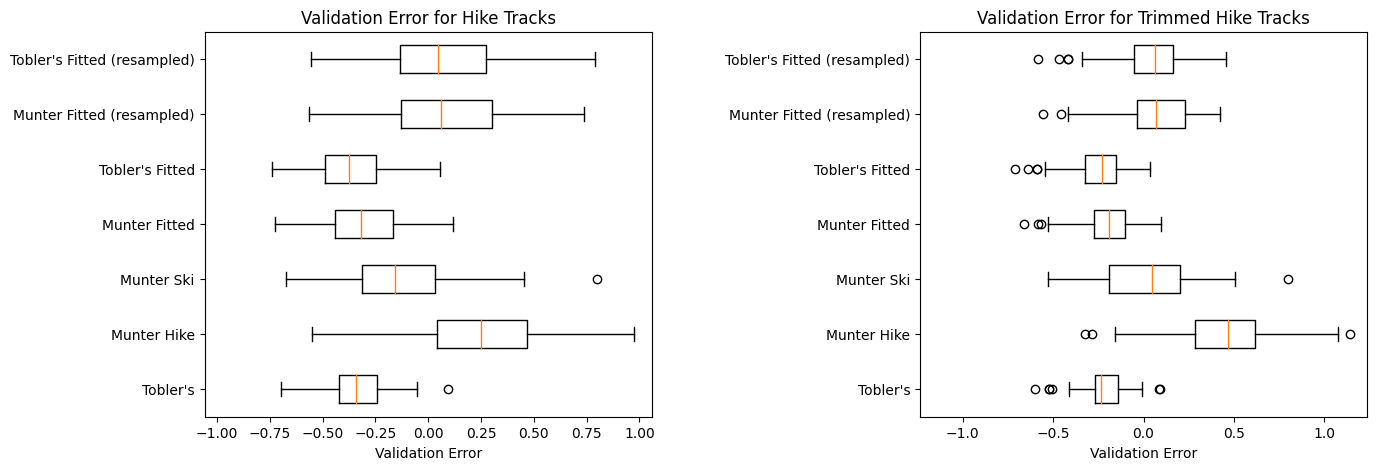

Error data for hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.6946,-0.42312,-0.341471,-0.241053,0.0923743,0.182067
Munter Hike,-0.551169,0.0422448,0.249435,0.466705,0.972652,0.424461
Munter Ski,-0.6707,-0.310926,-0.157491,0.0320515,0.800865,0.342978
Munter Fitted,-0.726976,-0.440981,-0.316653,-0.167775,0.116601,0.273206
Tobler's Fitted,-0.736948,-0.486075,-0.375976,-0.24612,0.0555632,0.239955
Munter Fitted (resampled),-0.564254,-0.12695,0.0595208,0.299937,0.735319,0.426887
Tobler's Fitted (resampled),-0.55233,-0.131755,0.0470747,0.272885,0.788969,0.40464


Error data for trimmed hike tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.600868,-0.269406,-0.236858,-0.140485,0.0923743,0.128921
Munter Hike,-0.323727,0.28344,0.466705,0.617929,1.14304,0.334489
Munter Ski,-0.526672,-0.188644,0.04643,0.203042,0.800865,0.391685
Munter Fitted,-0.660149,-0.276131,-0.189681,-0.100491,0.0967329,0.17564
Tobler's Fitted,-0.709703,-0.324783,-0.231839,-0.152142,0.0332334,0.172641
Munter Fitted (resampled),-0.557318,-0.0344138,0.0686806,0.227009,0.423123,0.261422
Tobler's Fitted (resampled),-0.583746,-0.0546401,0.0642677,0.165185,0.457602,0.219825


In [290]:
# Analysis, how much better did we do with fitting for Hike tracks? 

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

hike_errors = get_errors_for_data(tracks_by_type[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_hike_fitted, 
     toblers_hike_fitted,
      munter_hike_fitted_resampled, 
     toblers_hike_fitted_resampled,
    ])

pacefunc_labels = ["Tobler's", 
                   "Munter Hike", 
                   "Munter Ski", 
                   "Munter Fitted", 
                   "Tobler's Fitted",
                   "Munter Fitted (resampled)", 
                   "Tobler's Fitted (resampled)"
                  ]

plot_errors(hike_errors,
            pacefunc_labels,
            "Validation Error for Hike Tracks",
            ax=axs[0])

hike_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_HIKE], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_hike_fitted_trimmed, 
     toblers_hike_fitted_trimmed,
     munter_hike_fitted_trimmed_resampled, 
     toblers_hike_fitted_trimmed_resampled,
    ])

plot_errors(hike_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Hike Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.6)

# Show the plot
plt.show()

print("Error data for hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed hike tracks")
display(HTML(
    boxplot_stats_table(
        hike_errors_trimmed,
        pacefunc_labels,
    )
))

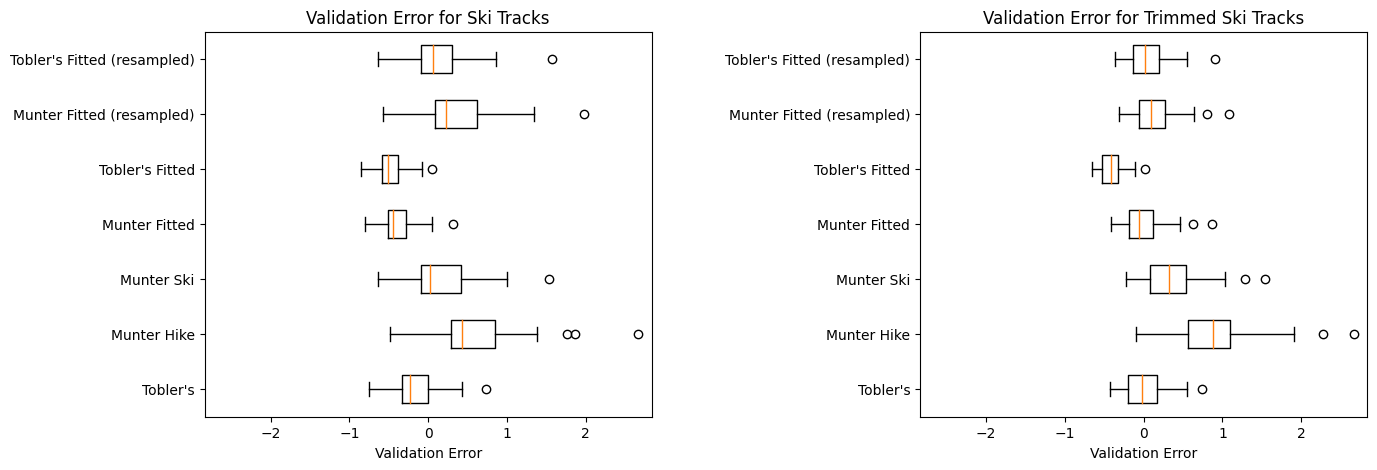

Error data for ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.747568,-0.326341,-0.232423,0.00327991,0.73554,0.32962
Munter Hike,-0.488748,0.285369,0.428108,0.85386,2.66589,0.568492
Munter Ski,-0.639719,-0.0869261,0.0297901,0.422645,1.53325,0.509571
Munter Fitted,-0.808608,-0.512957,-0.442144,-0.276678,0.318278,0.236279
Tobler's Fitted,-0.847964,-0.586447,-0.516159,-0.383246,0.0512875,0.203201
Munter Fitted (resampled),-0.568175,0.0826512,0.222305,0.616921,1.97867,0.534269
Tobler's Fitted (resampled),-0.636848,-0.0960667,0.0606794,0.307105,1.57323,0.403172


Error data for trimmed ski tracks


pacefunc,min error,25th percentile error,50th percentile error,75th percentile error,max error,IQR
Tobler's,-0.424186,-0.196397,-0.0205109,0.175277,0.736631,0.371674
Munter Hike,-0.0999253,0.562524,0.876581,1.10227,2.66774,0.539746
Munter Ski,-0.216255,0.0814588,0.325991,0.536884,1.53483,0.455426
Munter Fitted,-0.410316,-0.179891,-0.0526845,0.113801,0.865547,0.293691
Tobler's Fitted,-0.653216,-0.532362,-0.41663,-0.325811,0.0173239,0.206552
Munter Fitted (resampled),-0.311274,-0.0627464,0.0910498,0.275521,1.08574,0.338268
Tobler's Fitted (resampled),-0.356528,-0.135054,0.0187075,0.196124,0.908913,0.331179


In [291]:
# Analysis, how much better did we do with fitting for Ski tracks? 

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ski_errors = get_errors_for_data(tracks_by_type[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_ski_fitted, 
     toblers_ski_fitted,
     munter_ski_fitted_resampled, 
     toblers_ski_fitted_resampled,
    ])

pacefunc_labels = ["Tobler's", 
                   "Munter Hike", 
                   "Munter Ski", 
                   "Munter Fitted", 
                   "Tobler's Fitted",
                   "Munter Fitted (resampled)", 
                   "Tobler's Fitted (resampled)"
                  ]

plot_errors(ski_errors,
            pacefunc_labels,
            "Validation Error for Ski Tracks",
            ax=axs[0])

ski_errors_trimmed = get_errors_for_data(tracks_by_type_trimmed[ACTIVITY_SKI], 
    [toblers_hiking_pace_standard, 
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=4),
     partial(munter_pace_peicewise, uphill_rate=4, flat_rate=6, downhill_rate=10), 
     munter_hike_fitted_trimmed, 
     toblers_ski_fitted_trimmed,
     munter_ski_fitted_trimmed_resampled, 
     toblers_ski_fitted_trimmed_resampled,
    ])

plot_errors(ski_errors_trimmed,
            pacefunc_labels,
            "Validation Error for Trimmed Ski Tracks",
            ax=axs[1])

fig.subplots_adjust(wspace=0.6)

# Show the plot
plt.show()

print("Error data for ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors,
        pacefunc_labels,
    )
))

print("Error data for trimmed ski tracks")
display(HTML(
    boxplot_stats_table(
        ski_errors_trimmed,
        pacefunc_labels,
    )
))